## Modularizing Code

In [1]:
import math
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# excetions show up normally
%xmode plain

# plots show up inline
%matplotlib inline

def get_device(no_gpu=False):
    """
    Returns one of cuda / mps / cpu based on availablity
    """
    if no_gpu is True:
        return torch.device("cpu")
    elif torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")


# Choose the default device
no_gpu = True
default_device = get_device(no_gpu)


# Needed to import modules from src
import sys
sys.path.append('..')


# Get Project Root (needed for reading config)
import os
projectRoot = os.path.dirname(os.getcwd())
print(projectRoot)

Exception reporting mode: Plain
e:\Karpathy-Makemore


#### Load Data and Associated Functions

In [2]:
from src.loadData import loadData
import src.utils as utils

all_data = loadData(projectRoot)
vocab = utils.get_vocab(all_data)
print(f"Vocab Length:{len(vocab)}")

encode, decode = utils.get_encode_decode(vocab)
print(f"Encode test: {encode("emma")}\tDecode test: {decode(encode("emma"))}")
# print(f"Encode test: {encode("e")}\tDecode test: {decode(encode("e"))}")

train_percentage = 0.8
train_boundary = math.ceil(len(all_data) * train_percentage)

cv_percentage = train_percentage + 0.1
cv_boundary = math.ceil(len(all_data) * cv_percentage)

train_data = all_data[:train_boundary]
cv_data = all_data[train_boundary:cv_boundary]
test_data = all_data[cv_boundary:]

print(f"Name Counts ==> All:{len(all_data)}\tTrain:{len(train_data)}\t Validation:{len(cv_data)}\tTest: {len(test_data)} ")

Vocab Length:27
Encode test: [5, 13, 13, 1]	Decode test: emma
Name Counts ==> All:32033	Train:25627	 Validation:3203	Test: 3203 


#### Create Samples from Data

In [3]:
import src.utils as utils

context_length = 3

xtr, ytr = utils.get_samples(train_data, encode, context_size=context_length)
Xtr, Ytr = torch.tensor(xtr, device=default_device), torch.tensor(ytr, device=default_device)

xcv, ycv = utils.get_samples(cv_data, encode, context_size=context_length)
Xcv, Ycv = torch.tensor(xcv, device=default_device), torch.tensor(ycv, device=default_device)

xtest, ytest = utils.get_samples(test_data, encode, context_size=context_length)
Xtest, Ytest = torch.tensor(xtest, device=default_device), torch.tensor(ytest, device=default_device)

print(f"Sample Sizes ==> Training:{Xtr.shape[0]}\tValidation:{Xcv.shape[0]}\tTest:{Xtest.shape[0]}")

Sample Sizes ==> Training:182784	Validation:22632	Test:22730


#### Importing Models from file

In [5]:
import src.Model as M

# Hyper Parameters
g = torch.Generator(device=default_device).manual_seed(2147483627)
feature_dim = 30
n_hidden = 200
# learning_rate = 0.1
minibatch_size = 100

lossi_tr = []
lossi_cv = []

# Define Model
model = M.Model(len(vocab), feature_dim, n_hidden, context_length, d=default_device)

for p in model.parameters():
    p.requires_grad = True

# Generate Words before Training Loop
words = M.generate(model, 
                 encode_func=encode, 
                 decode_func=decode, 
                 start_ch=".", 
                 context_length=context_length, 
                 count=10, 
                 max_char=10,
                 d=default_device)
words

['qlgeuvmcpm',
 'chelsyuqav',
 'xkusyyfrhx',
 'kuqvwrcpkh',
 'xctrasfqzj',
 'ncdaohztvp',
 'xtxmxodlyj',
 'myvmifuxml',
 'nzntvmalkp',
 'teptbgaagl']

#### Training Loop

Epoch:0 Training Loss: 3.298332145214081	 Validation Loss:3.3023638415336607
Epoch:1000 Training Loss: 2.3004084646701815	 Validation Loss:2.4954251432418824
Epoch:2000 Training Loss: 2.2232954943180085	 Validation Loss:2.462770302295685
Epoch:3000 Training Loss: 2.1884109485149383	 Validation Loss:2.4406489896774293
Epoch:4000 Training Loss: 2.1435449993610383	 Validation Loss:2.4239186024665833
Epoch:5000 Training Loss: 2.136190588474274	 Validation Loss:2.392506663799286
Epoch:6000 Training Loss: 2.1304154455661775	 Validation Loss:2.4062440466880797
Epoch:7000 Training Loss: 2.109943984746933	 Validation Loss:2.3906280469894408
Epoch:8000 Training Loss: 2.0881055784225464	 Validation Loss:2.3882755541801455
Epoch:9000 Training Loss: 2.111015852689743	 Validation Loss:2.3903227996826173


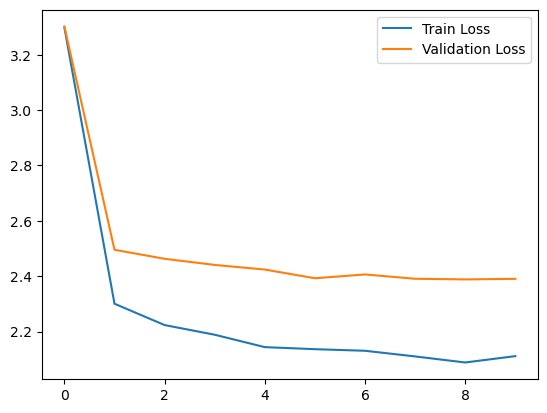

In [6]:
epochs = 10000
learning_rate = 0.1

for epoch in range(epochs):

    # Minibatch
    ix = torch.randint(Xtr.shape[0], size=(minibatch_size,), device=default_device, generator=g)
    X, Y = Xtr[ix], Ytr[ix]

    # Forward Pass
    model.train()
    logits = model(X)

    # Loss 
    loss = F.cross_entropy(logits, Y)
    if epoch % 1000 == 0:
        model.eval()
        lossi_tr.append(M.estimateError(Xtr, Ytr, model))
        lossi_cv.append(M.estimateError(Xcv, Ycv, model))
        print(f"Epoch:{epoch} Training Loss: {lossi_tr[-1]}\t Validation Loss:{lossi_cv[-1]}")
        model.train()

    # Zero Grad
    for p in model.parameters():
        p.grad = None

    # Backward Pass
    loss.backward()
    
    # Update Weight
    for p in model.parameters():
        p.data -= learning_rate * p.grad

plt.plot(lossi_tr, label="Train Loss")
plt.plot(lossi_cv, label="Validation Loss")
plt.legend(loc="upper right")
plt.show()

In [7]:
words = M.generate(model, 
                 encode_func=encode, 
                 decode_func=decode, 
                 start_ch=".", 
                 context_length=context_length, 
                 count=10, 
                 max_char=10,
                 d=default_device)

words

['kahlareel',
 'aya',
 'yuslee',
 'alandoryn',
 'kiyannie',
 'tzer',
 'vion',
 'brithana',
 'graien',
 'rosan']